Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



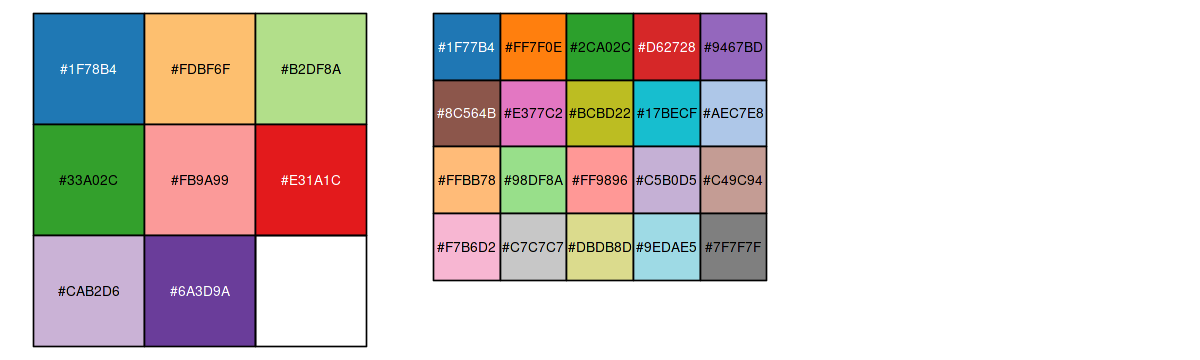

In [1]:
source("/home/siluo/public/SiyuanLuo/projects/benchmark_paper/analysis/utils.R")

options(repr.plot.width=10, repr.plot.height=3)
par(mfrow=c(1,3))

show_col(my_col_m3)
category20 <- c(
  "Matisse" = "#1F77B4", "Flamenco" = "#FF7F0E",
  "ForestGreen" = "#2CA02C", "Punch" = "#D62728",
  "Wisteria" = "#9467BD", "SpicyMix" = "#8C564B",
  "Orchid" = "#E377C2", 
  "KeyLimePie" = "#BCBD22", "Java" = "#17BECF",
  "Spindle" = "#AEC7E8", "MaC" = "#FFBB78",
  "Feijoa" = "#98DF8A", "MonaLisa" = "#FF9896",
  "LavenderGray" = "#C5B0D5", "Quicksand" = "#C49C94",
  "Chantilly" = "#F7B6D2", "Silver" = "#C7C7C7",
  "Deco" = "#DBDB8D", "RegentStBlue" = "#9EDAE5","Gray" = "#7F7F7F"
)
show_col(category20)

library(stringr)
library(Seurat)

In [2]:
labels1 <- c('B intermediate','B memory','B naive','CD4 Naive_1','CD4 Naive_2','CD4 TCM','CD8 Naive_1','CD8 Naive_2','CD8 TEM_1','CD8 TEM_2','CD14 Mono','CD16 Mono','NK','cDC2','pDC')
labels2 <- c('Astro','L2/3 IT','L4_1','L4_2','L5 PT','L5/6 IT','L6 CT','L6 IT','NP','Oligo','Pvalb','Sst','Vip/Lamp5')

In [3]:
methods <- c("ArchR_peaks", "ArchR_tiles", "Signac_all_cell_peaks", "Signac_by_cluster_peaks", "SnapATAC", "SnapATAC2_cosine", "SnapATAC2_jaccard", "aggregation")
datasets <- c("10XPBMC", "Chen2019")

# GLUE

In [9]:
df_fos <- data.frame(barcode=c(), FOSCTTM=c(), method=c(), dataset=c())
for(i in 1:length(methods)){
    for(dataset in datasets){
        method <- methods[i]
        # fos <- read.table(paste0("/home/siluo/public/SiyuanLuo/projects/rebuttal/integration/outputs/", dataset, "/", method, "/HVG_True_selected_atac_True/FOSCTTM.csv"), header=TRUE, sep=",", comment.char = "!")
        fos <- read.table(paste0("/home/siluo/public/SiyuanLuo/projects/rebuttal/integration/outputs/", dataset, "/", method, "/HVG_True_selected_atac_True/FOSCTTM_cosine.csv"), header=TRUE, sep=",", comment.char = "!")
        fos$method <- method
        fos$dataset <- dataset
        df_fos <- rbind(df_fos, fos)
    }
}
df_fos$barcode <- sub("CellinFile1#","",df_fos$barcode)

In [10]:
ann1 <- read.table("/home/siluo/public/SiyuanLuo/projects/benchmark/cleaned_data/PBMC_multiomics/PBMC_multiomics_RNA_annotation.txt", header=TRUE, sep="\t")
ann2 <- read.table("/home/siluo/public/SiyuanLuo/projects/benchmark/cleaned_data/Chen_2019/Chen_2019_RNA_annotation.txt", header=TRUE, sep="\t")

In [11]:
dim(df_fos)

[1] 110072      6

In [12]:
df_fos <- merge(df_fos, ann1, by.x="barcode", by.y="rna_barcode", all.x=TRUE)

In [13]:
df_fos <- merge(df_fos, ann2, by.x="barcode", by.y="barcode", all.x=TRUE)
df_fos$final_label <- ifelse(is.na(df_fos$final_label.x), df_fos$final_label.y, df_fos$final_label.x)

In [14]:
df_med <- df_fos %>% 
group_by(dataset, method)  %>%
summarise(med_value = median(FOSCTTM)) %>%
ungroup()

df_med

`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


dataset,method,med_value
<chr>,<chr>,<dbl>
10XPBMC,ArchR_peaks,0.03376563
10XPBMC,ArchR_tiles,0.02611286
10XPBMC,Signac_all_cell_peaks,0.02260778
10XPBMC,Signac_by_cluster_peaks,0.03306461
10XPBMC,SnapATAC,0.01942400
10XPBMC,SnapATAC2_cosine,0.01886903
10XPBMC,SnapATAC2_jaccard,0.02459399
10XPBMC,aggregation,0.03581026
Chen2019,ArchR_peaks,0.04626780


In [15]:
median_median1 <- median(df_med[df_med$dataset=="10XPBMC",]$med_value)
median_median1

[1] 0.02535343

In [16]:
median_median2 <- median(df_med[df_med$dataset=="Chen2019",]$med_value)
median_median2

[1] 0.03313775

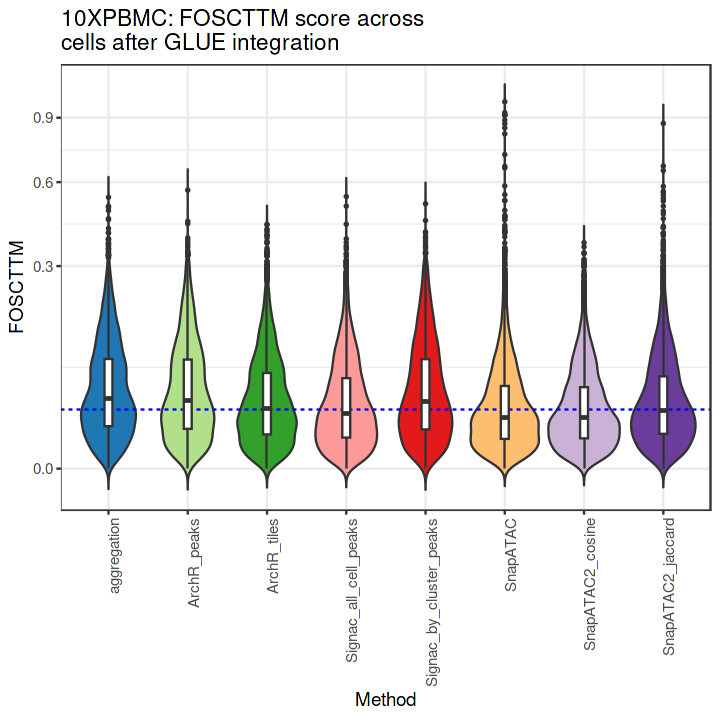

In [29]:
options(repr.plot.width=6, repr.plot.height=6)

p1 <- df_fos %>% filter(dataset == "10XPBMC") %>%
ggplot(aes(x=method, y=FOSCTTM, fill=method)) +
  geom_violin(trim=FALSE) + 
  geom_hline(yintercept = median_median1, linetype = "dashed", color = "blue", linewidth=0.5) +
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x="Method", y="FOSCTTM") + theme(legend.position = "none") + 
  scale_fill_manual(values = my_col_m3[c(1,3,4,5,6,2,7,8)])  +
  ggtitle(str_wrap("10XPBMC: FOSCTTM score across cells after GLUE integration", width=30)) +
  scale_y_continuous(trans='sqrt')
p1

## composition of the fraction

Warning message:
“Removed 1064 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 1064 rows containing non-finite values (`stat_boxplot()`).”


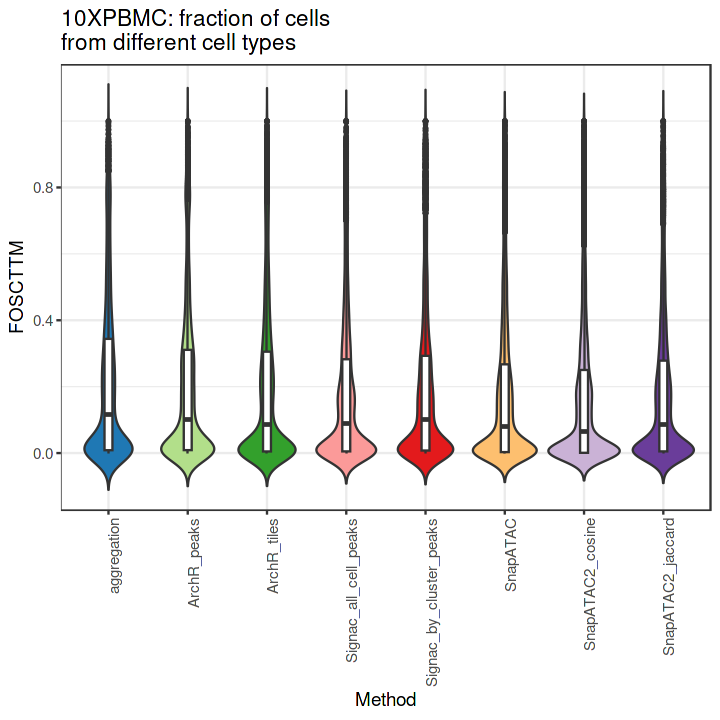

In [18]:
options(repr.plot.width=6, repr.plot.height=6)

p1.1 <- df_fos %>% filter(dataset == "10XPBMC") %>%
ggplot(aes(x=method, y=FOSCTTM_diff, fill=method)) +
  geom_violin(trim=FALSE) + 
#   geom_hline(yintercept = max_median, linetype = "dashed", color = "blue", linewidth=1) +
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x="Method", y="FOSCTTM") + theme(legend.position = "none") + 
  scale_fill_manual(values = my_col_m3[c(1,3,4,5,6,2,7,8)])  +
  ggtitle(str_wrap("10XPBMC: fraction of cells from different cell types", width=30)) #+
  # scale_y_continuous(trans='sqrt')
p1.1

In [10]:
df_fos <- df_fos[order(df_fos$method, df_fos$final_label, -df_fos$FOSCTTM), ]
df_fos[,"final_label"] <- as.factor(df_fos[,"final_label"])
df_fos$name <- as.factor(1:(nrow(df_fos)/8))
mapping <- aes_string(x="name", y="FOSCTTM", fill="final_label")

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


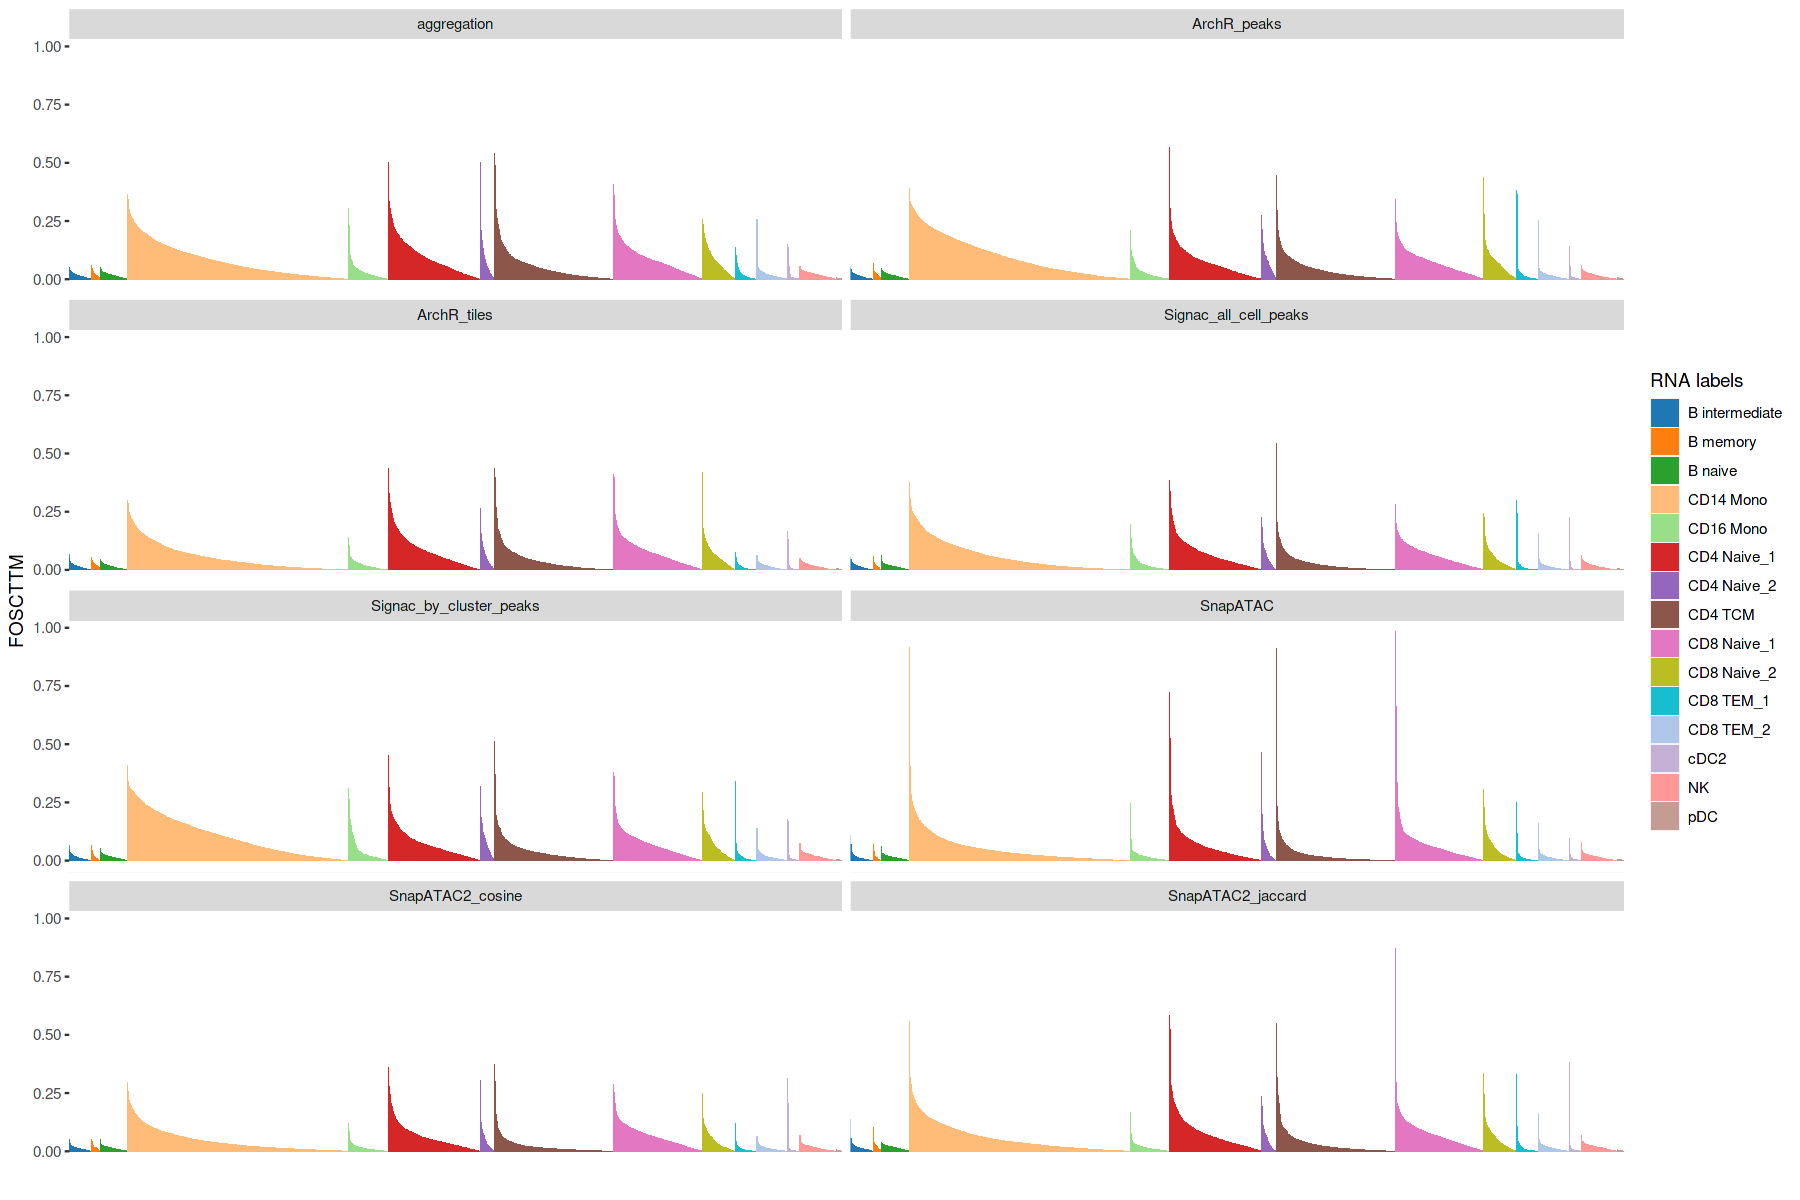

In [33]:
options(repr.plot.width=15, repr.plot.height=10)

col_v <- category20[1:length(labels1)]
names(col_v) <- unique(labels1)

p3 <- df_fos %>% 
filter(dataset=="10XPBMC") %>% 
# filter(method=="SnapATAC2_jaccard")  %>% 
ggplot() + 
geom_bar(stat = "identity", mapping) +
facet_wrap(~method, ncol=2) +
labs(y = "FOSCTTM", x = "", fill = "RNA labels") +
scale_fill_manual(values = col_v)


p3 <- p3 + theme(axis.text.x = element_blank(), 
                axis.ticks.x = element_blank())

p3

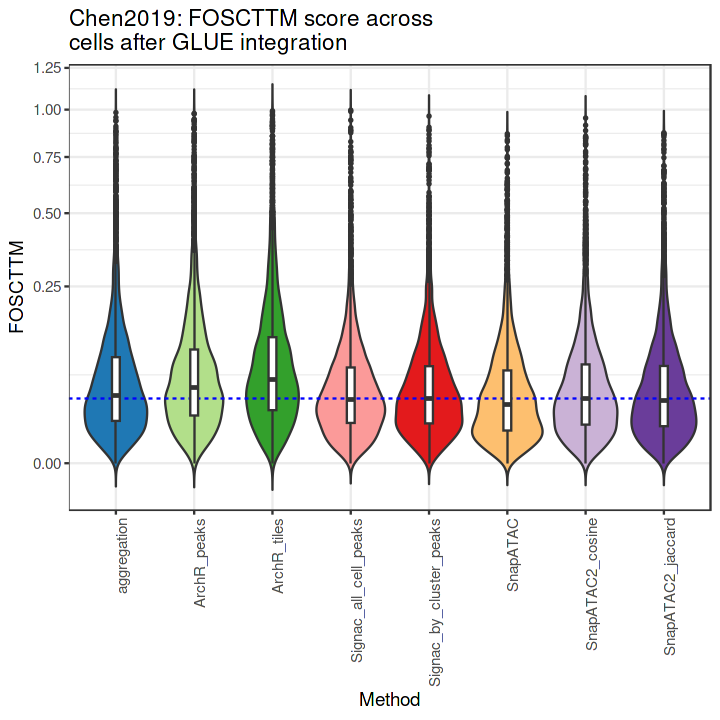

In [32]:
options(repr.plot.width=6, repr.plot.height=6)

p2 <- df_fos %>% filter(dataset == "Chen2019") %>%
ggplot(aes(x=method, y=FOSCTTM, fill=method)) +
  geom_violin(trim=FALSE) + 
  geom_hline(yintercept = median_median2, linetype = "dashed", color = "blue", linewidth=0.5) +
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.5) + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x="Method", y="FOSCTTM", fill="Method") + theme(legend.position = "none") + 
  scale_fill_manual(values = my_col_m3[c(1,3,4,5,6,2,7,8)]) +
  ggtitle(str_wrap("Chen2019: FOSCTTM score across cells after GLUE integration", width=30)) +
  scale_y_continuous(trans='sqrt')

p2

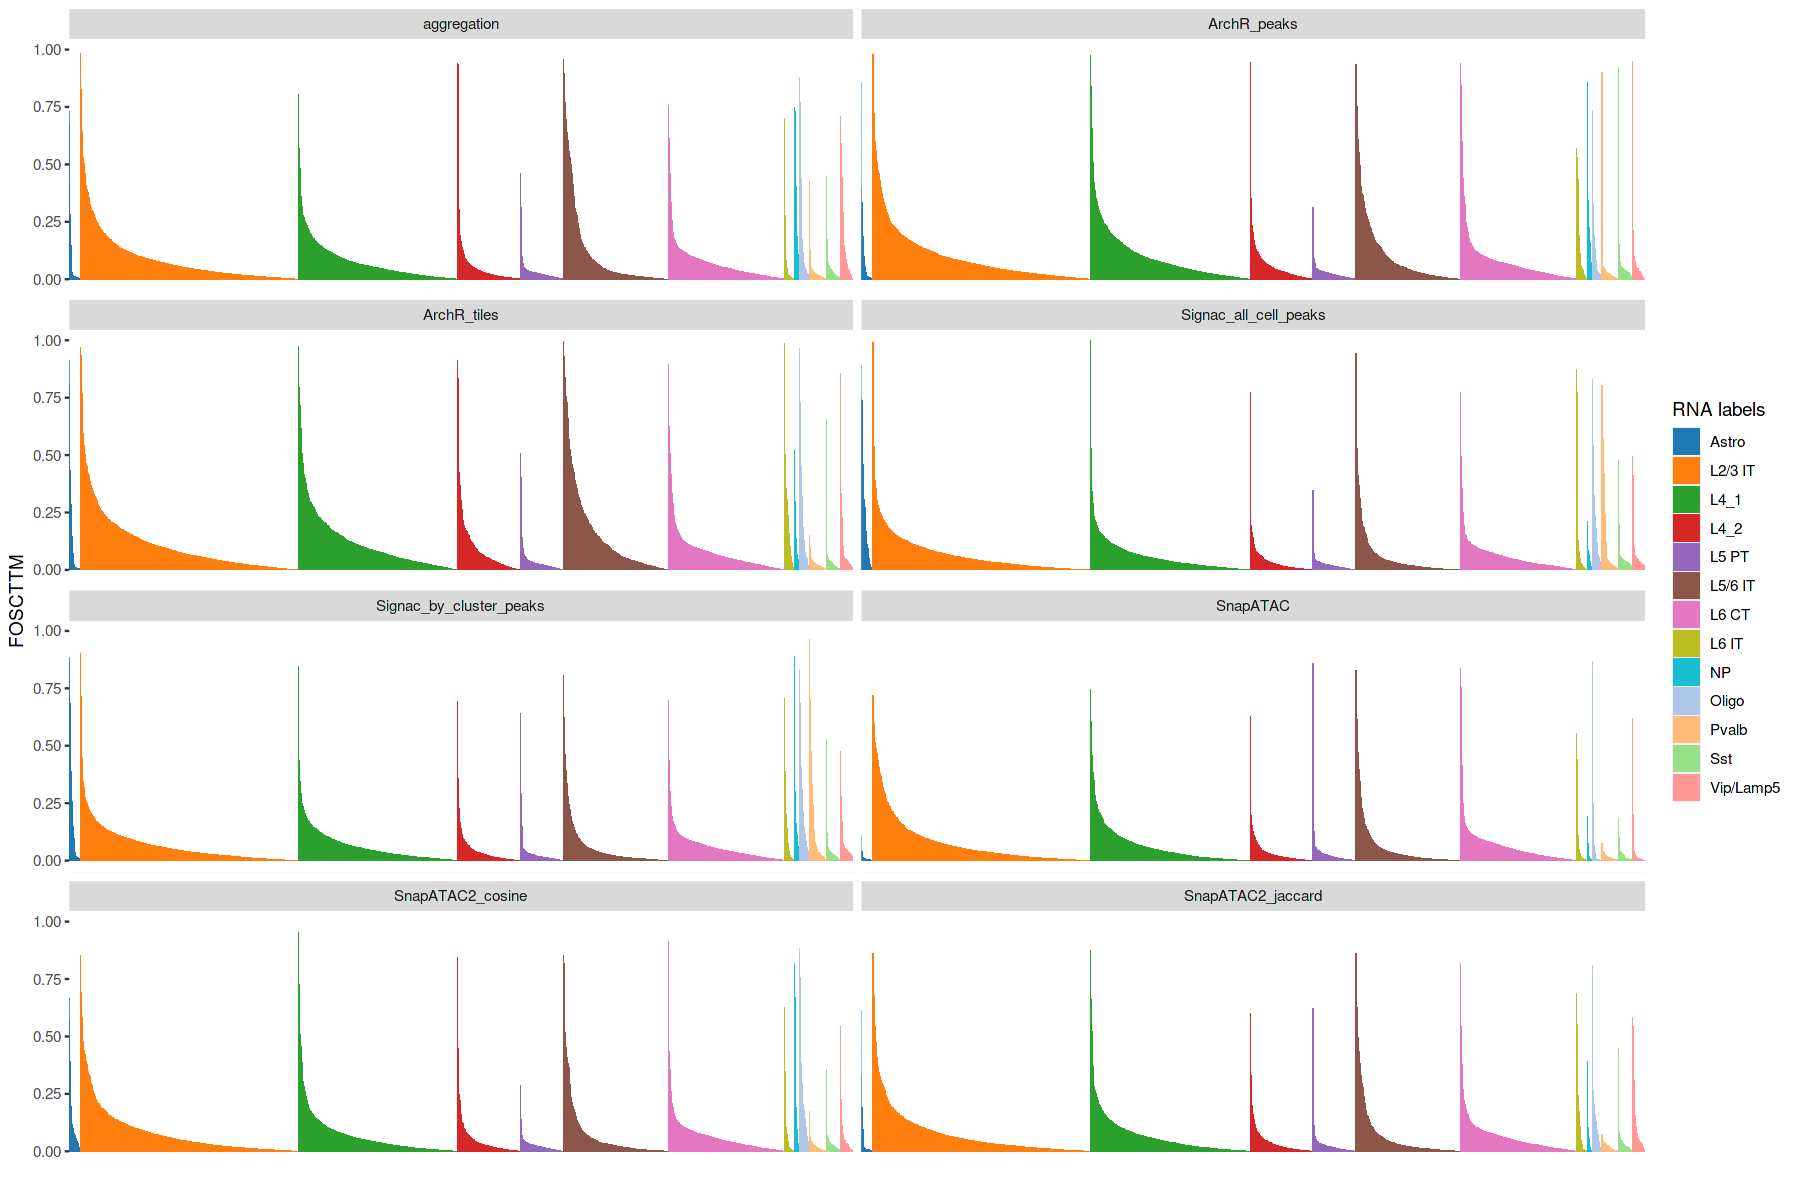

In [34]:
options(repr.plot.width=15, repr.plot.height=10)

col_v <- category20[1:length(labels2)]
names(col_v) <- unique(labels2)

p4 <- df_fos %>% 
filter(dataset=="Chen2019") %>% 
# filter(method=="SnapATAC2_jaccard")  %>% 
ggplot() + 
geom_bar(stat = "identity", mapping) +
facet_wrap(~method, ncol=2) +
labs(y = "FOSCTTM", x = "", fill = "RNA labels") +
scale_fill_manual(values = col_v)


p4 <- p4 + theme(axis.text.x = element_blank(), 
                axis.ticks.x = element_blank())

p4

In [47]:
pdf("FOSCTTM_eucl.pdf", width=4, height=5)
plot(p1)
plot(p2)
dev.off() 

png 
  2

In [ ]:
pdf("FOSCTTM_distr_eucl.pdf", width=12, height=8)
plot(p3)
plot(p4)
dev.off() 

In [35]:
pdf("FOSCTTM_cosine.pdf", width=4, height=5)
plot(p1)
plot(p2)
dev.off() 

png 
  2

In [36]:
pdf("FOSCTTM_distr_cosine.pdf", width=12, height=8)
plot(p3)
plot(p4)
dev.off() 

png 
  2

# WNN

In [4]:
df_m <- data.frame(metric=c(), value=c(), method=c(), dataset=c(), k=c())
for(i in 1:length(methods)){
    for(dataset in datasets){
        method <- methods[i]
        mm <- read.table(paste0("/home/siluo/public/SiyuanLuo/projects/rebuttal/integration/outputs/", dataset, "/", method, "/metric.tsv"), header=TRUE, sep="\t")
        sobj <- readRDS(paste0("/home/siluo/public/SiyuanLuo/projects/rebuttal/integration/outputs/", dataset, "/", method, "/sobj.RDS"))
        coln <- grep("wsnn", colnames(sobj@meta.data), value=TRUE)
        k <- max(as.numeric(unique(unlist(sobj[[coln]]))))
        mm$method <- method
        mm$dataset <- dataset
        mm$k <- k
        df_m <- rbind(df_m, mm)
        
    }
}

In [5]:
df_m %>% 
  select(method, dataset, k) %>% 
  distinct()

,method,dataset,k
,<chr>,<chr>,<dbl>
ARI,ArchR_peaks,10XPBMC,10
ARI1,ArchR_peaks,Chen2019,12
ARI3,ArchR_tiles,10XPBMC,12
ARI4,ArchR_tiles,Chen2019,8
ARI5,Signac_all_cell_peaks,10XPBMC,11
ARI6,Signac_all_cell_peaks,Chen2019,11
ARI7,Signac_by_cluster_peaks,10XPBMC,10
ARI8,Signac_by_cluster_peaks,Chen2019,12
ARI9,SnapATAC,10XPBMC,13


In [12]:
df_m

,metric,value,method,dataset,k
,<chr>,<dbl>,<chr>,<chr>,<dbl>
ARI,ARI,0.86724487,ArchR_peaks,10XPBMC,10
AMI,AMI,0.81538865,ArchR_peaks,10XPBMC,10
MI,MI,1.84477052,ArchR_peaks,10XPBMC,10
VI,VI,0.53578123,ArchR_peaks,10XPBMC,10
AW,AW,0.95908330,ArchR_peaks,10XPBMC,10
AV,AV,0.79145767,ArchR_peaks,10XPBMC,10
AW2,AW2,0.92438466,ArchR_peaks,10XPBMC,10
AV2,AV2,0.74614408,ArchR_peaks,10XPBMC,10
ARI2,ARI2,0.82575549,ArchR_peaks,10XPBMC,10


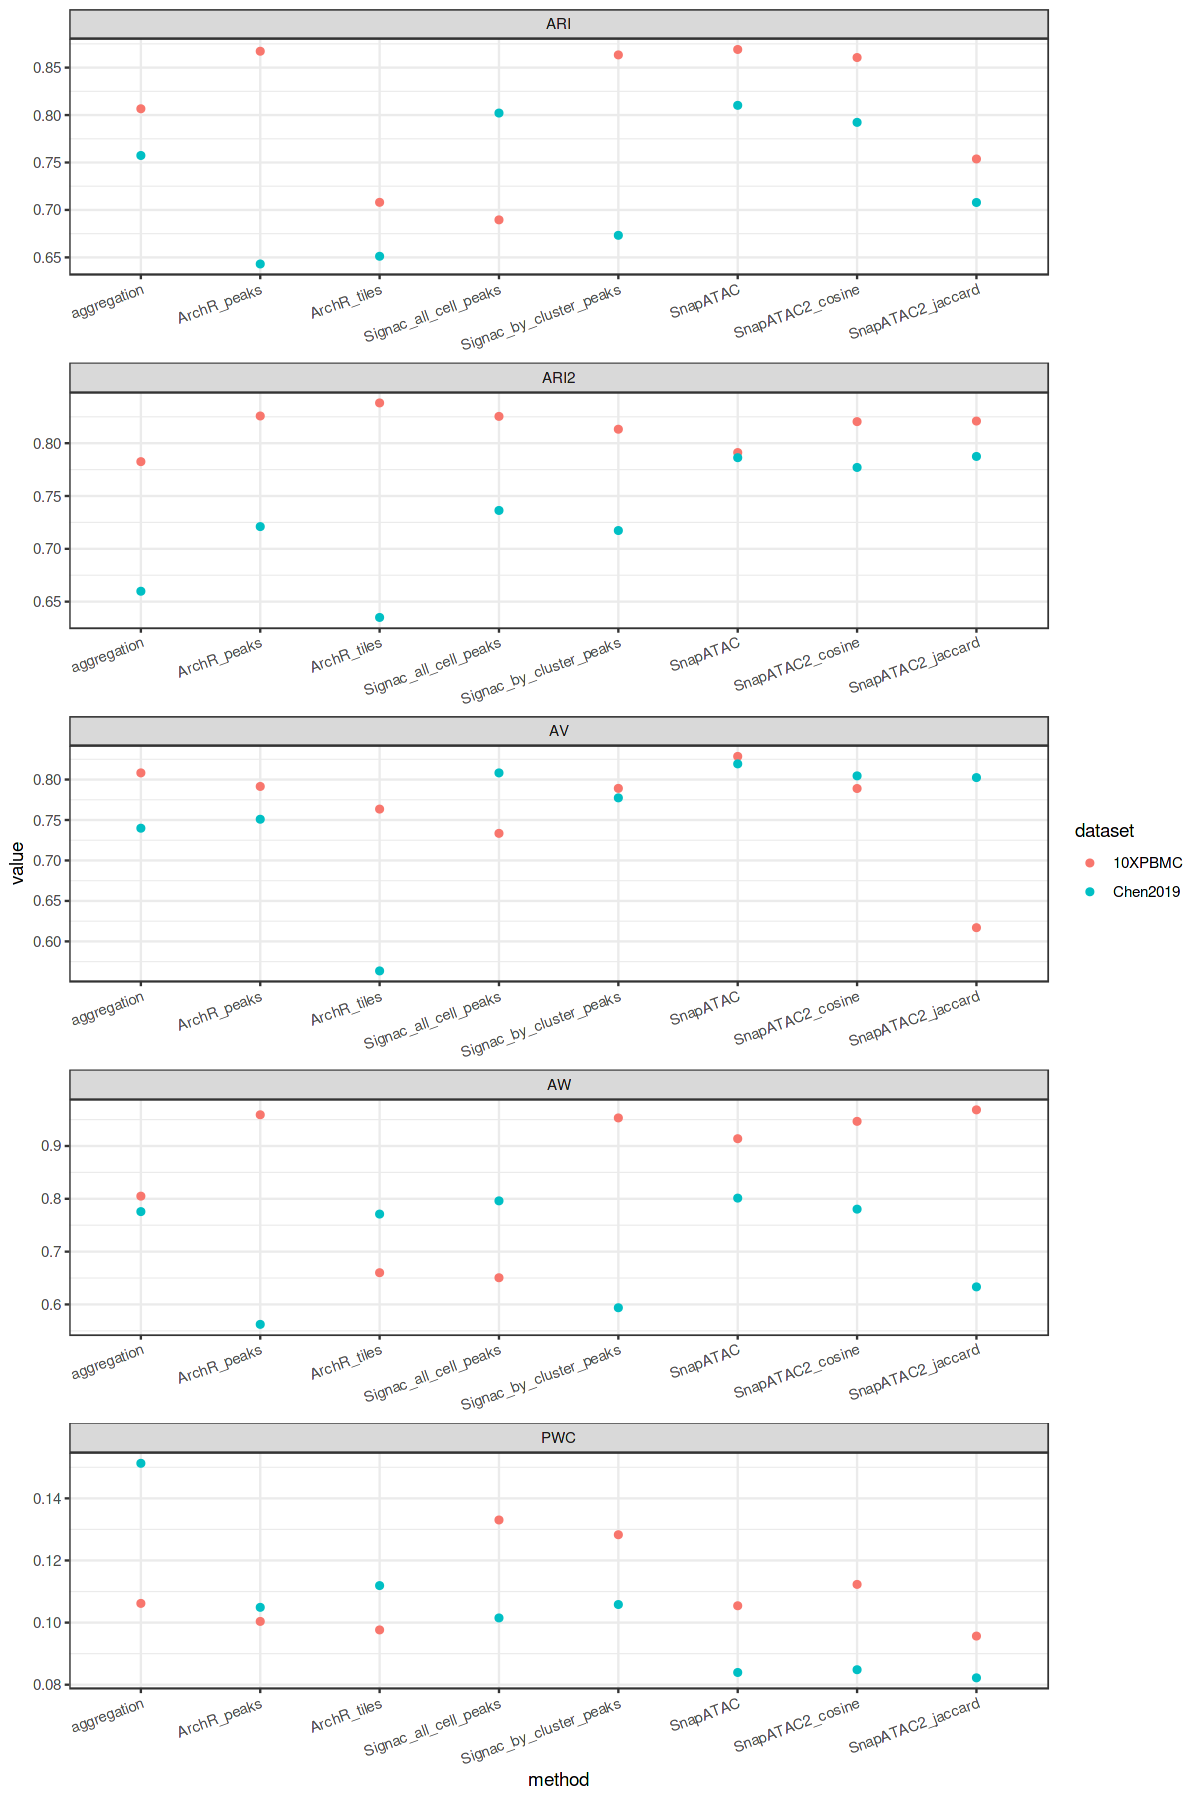

In [10]:
options(repr.plot.width=10, repr.plot.height=15)
p5 <- df_m %>% filter(metric %in% c("ARI", "ARI2", "AV", "AW", "PWC")) %>%
ggplot(aes(x=method, y=value, color=dataset)) +
geom_point() +
facet_wrap(~metric, ncol=1, scales = "free") + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1)) 

p5

In [11]:
pdf("wnn_metrics.pdf", width=8, height=12)
plot(p5)
dev.off() 

png 
  2

## Old results

In [6]:
dataset_ls <- c("Cell_line_mixing", "candidate1",  "candidate2", "Buenrostro_2018",  "Chen_2019",  "PBMC_multiomics") 
dataset_name <- c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC")
k_ls <- c(10, 13, 10, 9, 13, 15)
file1 <- "/home/siluo/public/SiyuanLuo/projects/benchmark_paper/result_files/results_meta_data.tsv"
file2 <- "/home/siluo/public/SiyuanLuo/projects/benchmark_paper/result_files/results_all_metrics.tsv"
df <- read.table(file1, sep='\t', header=TRUE)
df_metrics <- read.table(file2, sep='\t', header=TRUE)
df_metrics$dataset <- factor(df_metrics$dataset, levels = c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC"))
df_metrics$long_method <- factor(df_metrics$long_method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))

df_g <- read.table("/home/siluo/public/SiyuanLuo/projects/benchmark_paper/result_files/graph_metric_all_ndim15.tsv", sep='\t', header=TRUE)
df_gs <- df_g %>% group_by(dataset, method) %>% mutate(average = mean(weak_frac)) %>% subset(select=c(method, dataset, average))
df_gs <- df_gs[!duplicated(df_gs), ]

mapping <- list("Cell line mixing experiment" = "Cell line", 
                     "human adult atlas subset1" = "Atlas1", 
                     "human adult atlas subset2" = "Atlas2",
                     "Buenrostro2018" = "Buenrostro2018",
                     "Chen2019" = "Chen2019",
                     "10X PBMC multiomics" = "10XPBMC")
df_gs <- df_gs %>% 
  mutate(dataset_short = case_when(as.character(dataset) %in% names(mapping) ~ mapping[[as.character(dataset)]],
                             TRUE ~ "Other"))
df_gs$dataset_short <- factor(df_gs$dataset_short, levels = dataset_name)

df_gs$method[df_gs$method=="SnapATAC1"] <- "SnapATAC"
df_gs$method <- factor(df_gs$method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))

mapping <- list("Cell line" = "1", 
                     "Atlas1" = "1", 
                     "Atlas2" = "1",
                     "Buenrostro2018" = "2",
                     "Chen2019" = "2",
                     "10XPBMC" = "2")
                     
df_gs <- df_gs %>% 
  mutate(dataset_type = case_when(as.character(dataset_short) %in% names(mapping) ~ mapping[as.character(dataset_short)]))
df_gs$dataset_type <- unlist(df_gs$dataset_type)

df_metrics_ari <- df_metrics %>% filter(metric == "ARI") %>% filter(ndim == 15)

In [7]:
df_gs <- df_gs %>% filter(dataset_short %in% c("10XPBMC", "Chen2019"))
df_gs <- df_gs[,c("method","dataset_short","average")]
colnames(df_gs) <- c("method","dataset","value")
df_gs$metric <- "PWC"

In [31]:
df_gs

method,dataset,value,metric
<fct>,<fct>,<dbl>,<chr>
aggregation,Chen2019,0.2958058,PWC
Signac_by_cluster_peaks,10XPBMC,0.1355316,PWC
Signac_all_cell_peaks,10XPBMC,0.1253412,PWC
ArchR_tiles,10XPBMC,0.1577160,PWC
ArchR_peaks,10XPBMC,0.1543443,PWC
SnapATAC,10XPBMC,0.1193810,PWC
aggregation,10XPBMC,0.1501749,PWC
SnapATAC2_jaccard,10XPBMC,0.1212698,PWC
SnapATAC2_cosine,10XPBMC,0.1429901,PWC


In [8]:
df_metrics_ari <- df_metrics_ari %>% filter(dataset %in% c("10XPBMC", "Chen2019"))
df_metrics_ari <- df_metrics_ari[,c("long_method","dataset","value", "metric")]
colnames(df_metrics_ari) <- c("method","dataset","value", "metric")
df_metrics_ari

method,dataset,value,metric
<fct>,<fct>,<dbl>,<chr>
Signac_by_cluster_peaks,Chen2019,0.5393057,ARI
Signac_by_cluster_peaks,Chen2019,0.5388041,ARI
Signac_by_cluster_peaks,Chen2019,0.5378293,ARI
Signac_by_cluster_peaks,Chen2019,0.5393057,ARI
Signac_by_cluster_peaks,Chen2019,0.5393057,ARI
Signac_by_cluster_peaks,Chen2019,0.6508117,ARI
Signac_by_cluster_peaks,Chen2019,0.6505702,ARI
Signac_by_cluster_peaks,Chen2019,0.6239613,ARI
Signac_by_cluster_peaks,Chen2019,0.6508117,ARI


In [9]:
df_m2 <- df_metrics_ari %>% 
  group_by(dataset, method, metric) %>%
  summarize(value = mean(value))

`summarise()` has grouped output by 'dataset', 'method'. You can override using
the `.groups` argument.


In [10]:
df_m2 <- rbind(df_m2, df_gs)
df_m2$type <- "ATAC only"
df_m$type <- "RNA+ATAC"

In [11]:
df_m2$k <- 0

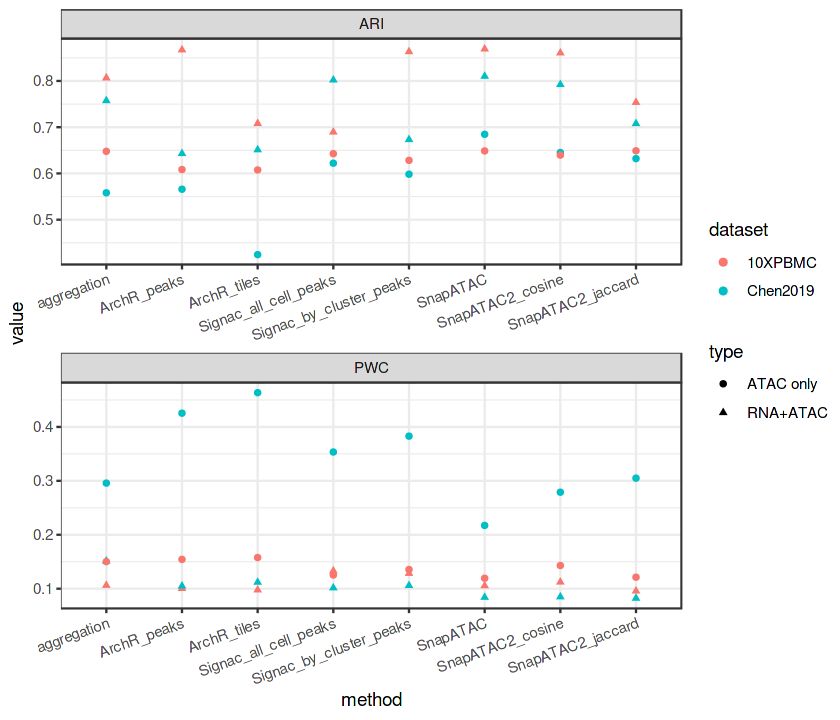

In [18]:
options(repr.plot.width=7, repr.plot.height=6)
p6 <- rbind(df_m, df_m2) %>% filter(metric %in% c("ARI", "PWC")) %>%
ggplot(aes(x=method, y=value, color=dataset, shape=type)) +
geom_point() +
facet_wrap(~metric, ncol=1, scales = "free") + 
  # scale_y_continuous(trans = my_sqrt_trans()) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1)) 

p6

In [19]:
df <- rbind(df_m, df_m2) %>% filter(metric %in% c("ARI", "PWC")) 

In [65]:
library(gridExtra)
library(grid)
library(ggpubr)

options(repr.plot.width=7, repr.plot.height=6)

# Create individual plots
p1 <- ggplot(subset(df, metric == "ARI"), aes(x=method, y=value, color=dataset, shape=type)) +
  geom_point() +
  ggtitle("ARI") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1)) #+
  # theme(legend.position = "none")

p2 <- ggplot(subset(df, metric == "PWC"), aes(x=method, y=value, color=dataset, shape=type)) +
  geom_point() +
  scale_y_continuous(trans = 'sqrt') +
  ggtitle("PWC") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1)) #+
  # theme(legend.position = "none") 

p3 <- ggplot(subset(df, metric == "PWC"), aes(x=method, y=value, color=dataset, shape=type)) +
  geom_point() +
  scale_y_continuous(trans = 'sqrt') +
  ggtitle("PWC") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
  theme(legend.background = element_blank(), plot.background = element_blank(), panel.background = element_blank())

# Extract legend
g <- ggplotGrob(p3)
leg <- g$grobs[[which(g$layout$name == "guide-box")]]
leg$bg <- NULL # Remove background from legend grob

# Combine plots
p7 <- ggarrange(p1, p2, nrow=2, common.legend = TRUE, legend="right")

In [50]:
pdf("wnn_metrics2.pdf", width=7, height=6)
plot(p6)
dev.off() 

png 
  2

In [66]:
pdf("wnn_metrics3.pdf", width=7, height=6)
plot(p7)
dev.off() 

png 
  2